In [261]:
import pandas as pd
import pdb
import random
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score
from numpy.random import multinomial
from sklearn.ensemble import GradientBoostingRegressor
import pickle

# Setup

In [262]:
rowCols = ['Percent Black', 'Percent White', 'Percent Asian', 'Percent Hispanic']
rankCols = [col + ' Ranking' for col in rowCols] 
neededCols = [rowCols[:1][0], 'Average Score (SAT Math)']
zip_to_boro = pd.read_csv('zip_borough.csv')
boros = ['Manhattan', 'Staten', 'Bronx', 'Queens', 'Brooklyn']
subjects = ['Math', 'Reading', 'Writing']
percent_spent_df = pd.read_csv('school_spend.csv')
training_cols = rowCols + ['Percent Other'] + boros + ['Spent Per Student', "Student enrollment"] + subjects
new_cols = rowCols + ['Percent Other'] + boros + ['Spent Per Student', "Student enrollment"]

In [263]:
df = pd.read_csv('scores.csv')
percent_spent_df['Spent Per Student'] = pd.to_numeric(percent_spent_df['Spent Per Student'].str.replace('[^a-zA-Z0-9]', ''))

In [264]:
df = pd.merge(df, percent_spent_df, how='inner', on='School Name')

# Data Cleaning

In [265]:
zip_to_boro.borough.unique()
boro_to_int = dict(zip(zip_to_boro.borough.unique(), [1,2,3,4,5]))
zip_to_boro['boro_id'] = zip_to_boro.borough.apply(lambda x: boro_to_int[x])
zip_to_boro = zip_to_boro.set_index('zip')

In [266]:
df['boro_id'] = df['Zip Code'].apply(lambda x: zip_to_boro.loc[x]['borough'])

In [267]:
for col in neededCols:
    df = df[pd.notnull(df[col])]
df.shape

(271, 28)

In [268]:
df = df.join(pd.get_dummies(df['boro_id']))

In [269]:
for col in rowCols:
    df[col] = pd.to_numeric(df[col].map(lambda pcnt: pcnt.strip('%')))

In [270]:
def getOther(row):
    return 100 - row[rowCols].sum()
df['Percent Other'] = df[rowCols].apply(getOther, axis=1)

In [271]:
new_rows = []
def extract_sat(row):
    for subject in ['Math', 'Reading', 'Writing']:
        new_row = row[new_cols].copy()
        new_row['SAT SCORE'] = row[f'Average Score (SAT {subject})']
        new_row['SAT TYPE'] = subject
        new_rows.append(new_row)
    return row
    
def extract_features(df):
    new_cols = pd.get_dummies(df['SAT TYPE'])
    df.drop(columns=['SAT TYPE'], inplace=True)
    df = df.join(new_cols)
    return df

df.apply(extract_sat, axis=1)
new_df = pd.concat(new_rows, axis=1)
new_df = new_df.transpose()
new_df = extract_features(new_df).drop_duplicates()
new_df.head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Manhattan,Staten,Bronx,Queens,Brooklyn,Spent Per Student,Student enrollment,SAT SCORE,Math,Reading,Writing
1,13.3,28.6,38.5,18,1.6,1,0,0,0,0,16571,1717,657,1,0,0
1,13.3,28.6,38.5,18,1.6,1,0,0,0,0,16571,1717,657,0,1,0
1,13.3,28.6,38.5,18,1.6,1,0,0,0,0,16571,1717,657,0,0,1
1,13.3,28.6,38.5,18,1.6,1,0,0,0,0,16571,1717,601,1,0,0
1,13.3,28.6,38.5,18,1.6,1,0,0,0,0,16571,1717,601,0,1,0


# Data Exploration

## Correlations

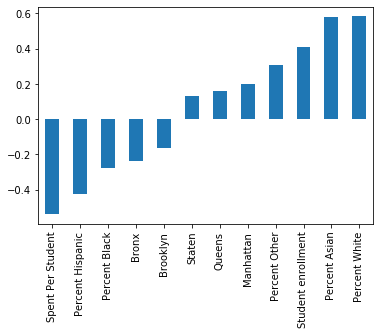

In [272]:
# new_df["SAT SCORE"]
for col in new_df.columns:
    new_df[col] = new_df[col].astype("float")
new_df.corr()["SAT SCORE"].sort_values().drop(labels=['SAT SCORE', 'Reading', 'Writing', 'Math']).plot(kind="bar")

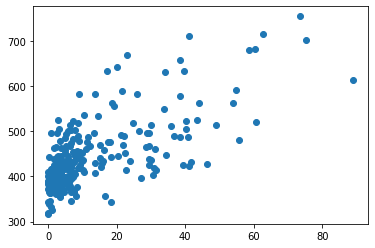

In [273]:
plt.scatter(df['Percent Asian'], df['Average Score (SAT Math)'])

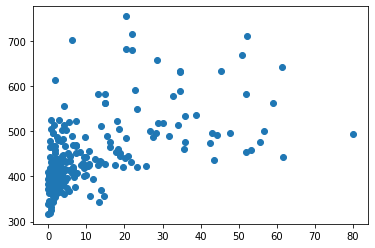

In [274]:
plt.scatter(df['Percent White'], df['Average Score (SAT Math)'])

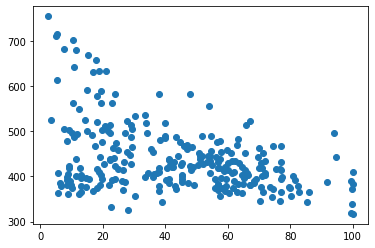

In [275]:
plt.scatter(df['Percent Hispanic'], df['Average Score (SAT Math)'])

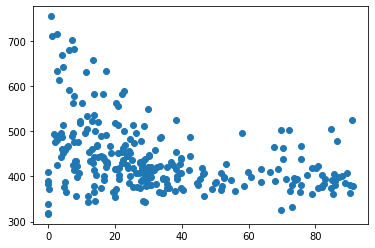

In [276]:
plt.scatter(df['Percent Black'], df['Average Score (SAT Math)'])

# Training, Predicting, & Validating Model

In [286]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(new_df[training_cols], new_df['SAT SCORE'])

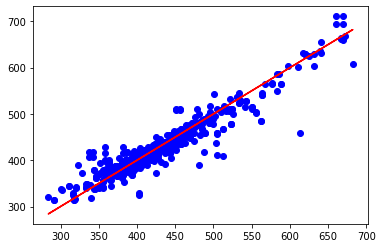

In [287]:
model = GradientBoostingRegressor(n_estimators=200, max_depth=6, loss='lad')

# train the model using the training sets
model.fit(x_train, y_train)

# make predicitons using the testing set
y_predictions = model.predict(x_test)

plt.xticks()
plt.yticks()
plt.scatter(y_test, y_predictions, color="blue")
plt.plot(y_test, y_test, color="red")

plt.show()

In [288]:
# The mean squared error
print("Mean squared error: %.2f"
     % mean_squared_error(y_test, y_predictions))

# Explained variance score: 1 is the perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_predictions))

# Explained r2 score: 1 is the best possible fit
print('R^2 score: %.2f' % r2_score(y_test, y_predictions))


Mean squared error: 453.14
Variance score: 0.90
R^2 score: 0.90


In [289]:
pickle.dump(model, open('primary_sat_model.sav', 'wb'))